In [1]:
%load_ext autoreload
%autoreload 2
#new way to load data
# the basic cuts are already in the select leaf
%matplotlib inline 
srcpwd = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/script'
utilspath =srcpwd + '/utils/'
sys.path.append(utilspath)
import utils
classpath = srcpwd + '/classes/'
sys.path.append(classpath)
import dataset
#datafolder = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/data/332_333/'
datafolder = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/data/'
#fname = 'Antenna_2014-01-01_2014-01-30.root'
fname = 'Antenna_2014-01-01_2014-12-31.root'                                                                                                        
file = datafolder + fname

data = dataset.Dataset(file)
data.loaddata()
pfile = '/Users/romain/work/Auger/EASIER/LPSC/suntransit/data/period/controlperiod_Tsys_50K_below_2adc.txt'
data.loadperiod(pfile)   

Welcome to ROOTaaS 6.06/00


In [2]:
#load the data for 343
data1 = data.getnewdatawithid(434)
pfile = '/Users/romain/work/Auger/EASIER/LPSC/suntransit/data/period/controlperiod_Tsys_50K_below_2adc.txt'
data1.loadperiod(pfile)                                                                                                                       
data1.selectleafs()

<matplotlib.colorbar.Colorbar instance at 0x12a3f5c20>

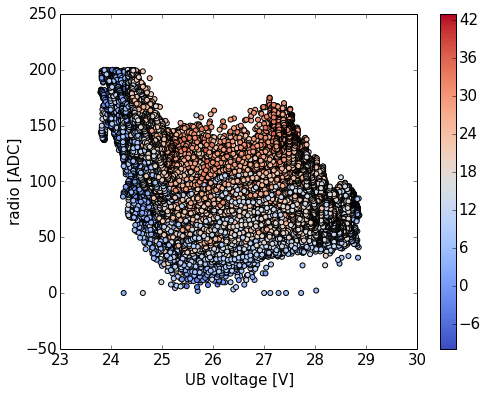

In [29]:
ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) ))
fig = plt.figure(figsize=(8,6))
vlim = 10
#plt.plot(ndata1.UBV[ndata1.UBV> vlim], ndata1.radio[ndata1.UBV>vlim],'.')
#plt.plot(ndata1.tempLL[ndata1.UBV> 1],ndata1.radio[ndata1.UBV>1],'.')
plt.scatter(ndata1.UBV[ndata1.UBV> vlim], ndata1.radio[ndata1.UBV>vlim],marker='.',s=100, c=ndata1.tempLL[ndata1.UBV> vlim], cmap=plt.cm.coolwarm)
plt.xlabel('UB voltage [V]')
plt.ylabel('radio [ADC]')
plt.colorbar()

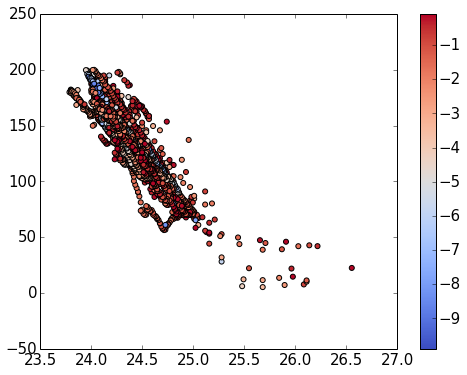

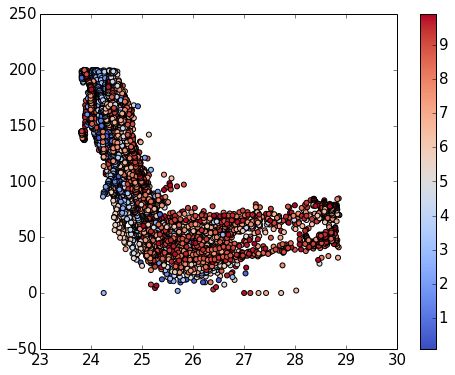

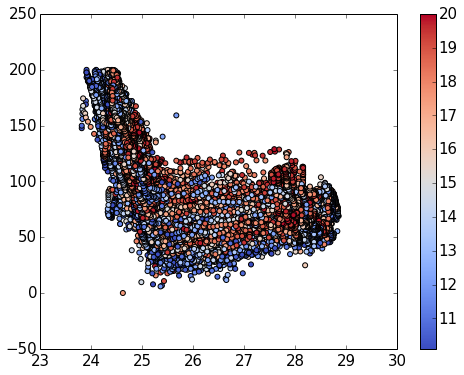

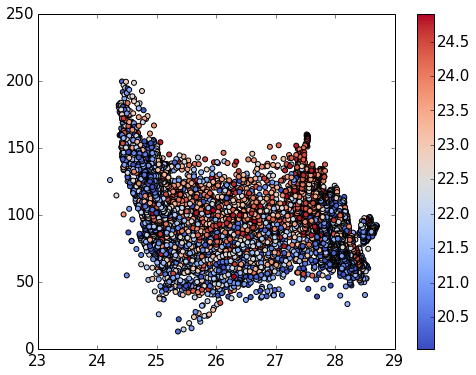

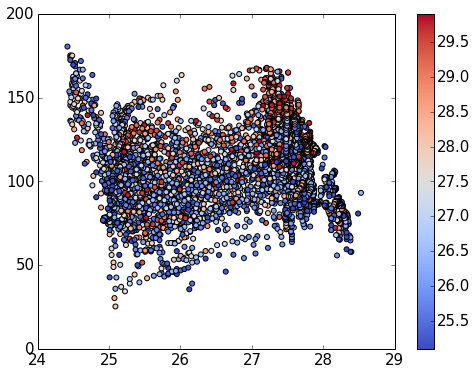

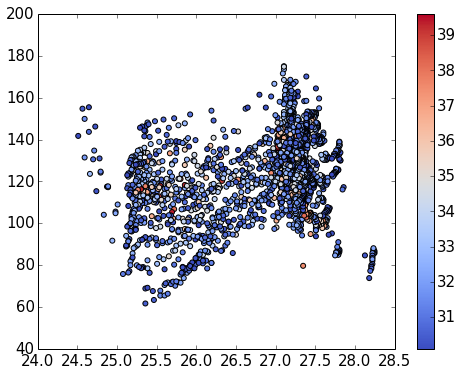

In [36]:
vlim =20
ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlim) ))
temp = np.array([-10,0,10,20,25,30,40])
for i in range(len(temp)-1):
    tlow = temp[i]
    tup = temp[i+1]
    tdata1 = ndata1.getnewdatasetcond(np.where( (ndata1.tempLL > tlow) & (ndata1.tempLL < tup) ))
    fig = plt.figure(figsize=(8,6))
    plt.scatter(tdata1.UBV, tdata1.radio,marker='.',s=100, c=tdata1.tempLL, cmap=plt.cm.coolwarm)
##plt.xlabel('UB voltage [V]')
#plt.ylabel('radio [ADC]')
    plt.colorbar()

28
[[Variables]]
    a1:  -107.262335 +/- 1.861105 (1.74%) (init=-100)
    b1:   2758.96278 +/- 45.72980 (1.66%) (init= 2700)
    a2:   2.82982171 +/- 3.663650 (129.47%) (init= 9)
    b2:  -26.4313029 +/- 96.02597 (363.30%) (init=-190)
    t:    25.3005678 +/- 0.038871 (0.15%)  == 'float((b2-b1))/(a1-a2)'
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
    C(a2, b2)                    = -1.000 


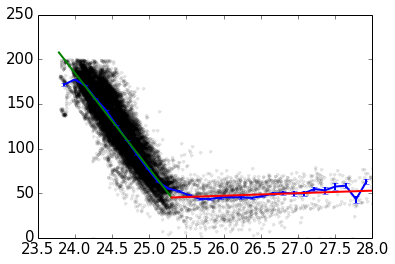

In [134]:
from lmfit import minimize, Parameters, Parameter, report_fit
def fcn2min(params, x, data, dataerr):
    """ model decaying sine wave, subtract data"""
    a1 = params['a1'].value
    b1 = params['b1'].value
    a2 = params['a2'].value
    b2 = params['b2'].value
    t = params['t'].value
    x1 = x[x<t]
    x2 = x[x>=t]
    y1 = a1*x1 + b1
    y2 = a2*x2 + b2
    model = np.array([])
    model = np.append(model,y1)
    model = np.append(model,y2)
#    model = a * x + b                                                                                          
    return (model - data)/dataerr

vlimup = 28
vlimlow = 23
ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow)   & (data1.UBV < vlimup)))
tlow = -10
tup = 10
tdata1 = ndata1.getnewdatasetcond(np.where( (ndata1.tempLL > tlow) & (ndata1.tempLL < tup) ))

x = tdata1.UBV
y = tdata1.radio
prof = utils.makeprofile(x,y,30,np.min(x),np.max(x))
sx = prof[0]
sy = prof[1]
params = Parameters()
params.add('a1', value=-100,max=0)
params.add('b1', value=2700,vary=True)
params.add('a2', value=9,min=0)
params.add('b2', value=-190)
params.add('t', value=25, expr='float((b2-b1))/(a1-a2)')

result = minimize(fcn2min, params, args=(sx, sy,prof[3]))
result = minimize(fcn2min, params, args=(sx, sy,prof[3]))
final = sy + result.residual
print result.nfev
report_fit(result.params)
t = result.params['t'].value
a1 = result.params['a1'].value
b1 = result.params['b1'].value
a2 = result.params['a2'].value
b2 = result.params['b2'].value
plt.plot(x, y, 'k.',zorder=-32,alpha=0.1)
plt.errorbar(sx, sy,yerr=prof[3],lw=2)
#plt.plot(sx, final,lw=3)
x1 = np.linspace(np.min(x),result.params['t'].value,20)
x2 = np.linspace(result.params['t'].value,np.max(x),20)
res1 = result.params['a1'].value*x1 + result.params['b1'].value
res2 = result.params['a2'].value*x2 + result.params['b2'].value
plt.plot(x1,res1,lw=2)
plt.plot(x2,res2,lw=2)

plt.show()





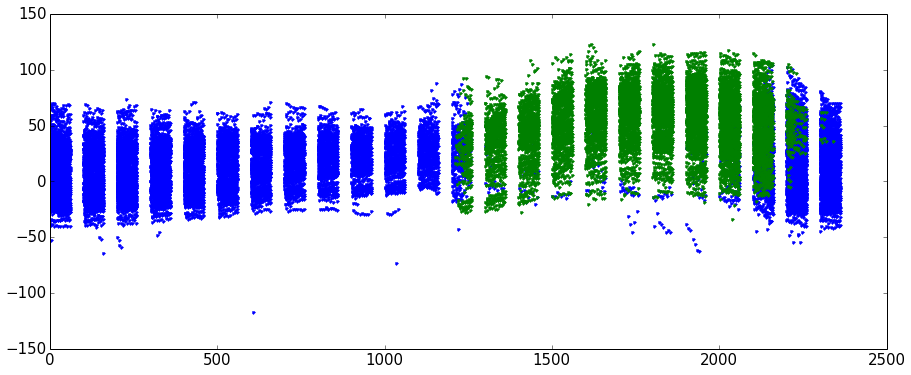

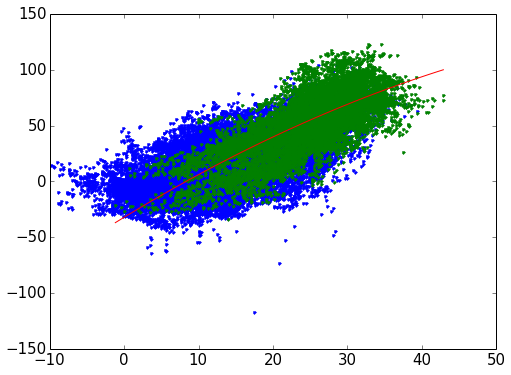

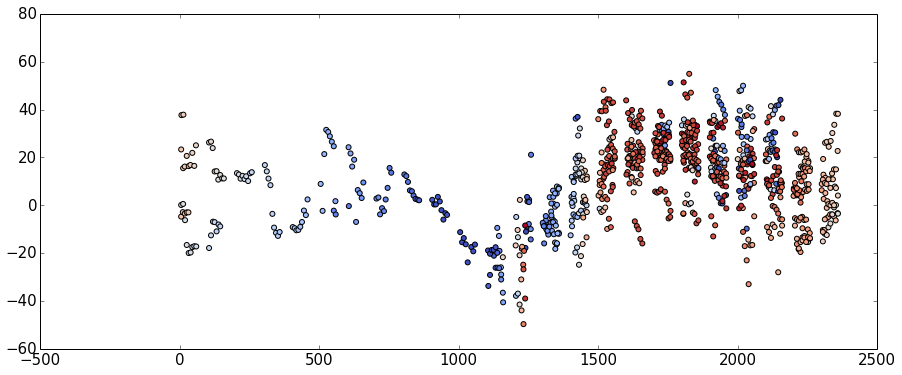

In [108]:
# try to correct data:
#   a1: -93.0803780 +/- 3.546215 (3.81%) (init=-100)
#    b1:   2408.61053 +/- 87.34978 (3.63%) (init= 2700)
#    a2:   5.55094615 +/- 1.926576 (34.71%) (init= 9)
#    b2:  -98.8599834 +/- 51.51457 (52.11%) (init=-190)
#    t:    25.4226590 +/- 0.044424 (0.17%)
a1= -93.080378
b1=   2408.61053 
a2=  5.55094615
b2=  -98.8599834
t = 25.4226590

ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow)  
                                              & (data1.UBV < vlimup) & (data1.humLL < 40)))
vdata1 = ndata1.getnewdatasetcond(np.where((ndata1.UBV < t)))
vdata2 = ndata1.getnewdatasetcond(np.where((ndata1.UBV > t)))

#plt.plot(vdata1.UBV, vdata1.radio - (a1* vdata1.UBV + b1) ,'.')
#plt.plot(vdata2.UBV, vdata2.radio - (a2* vdata2.UBV + b2) ,'.')
#plt.plot(ndata1.date,ndata1.radio-np.mean(ndata1.radio))
fig = plt.figure(figsize=(15,6))
#plt.plot(ndata1.hhmm,ndata1.radio-np.mean(ndata1.radio),'.')
plt.plot(vdata1.hhmm,vdata1.radio - (a1* vdata1.UBV + b1),'.')
plt.plot(vdata2.hhmm,vdata2.radio - (a2* vdata2.UBV + b2),'.')

fig2 = plt.figure(figsize=(8,6))
#plt.plot(ndata1.hhmm,ndata1.radio-np.mean(ndata1.radio),'.')
plt.plot(vdata1.tempLL,vdata1.radio - (a1* vdata1.UBV + b1),'.')
plt.plot(vdata2.tempLL,vdata2.radio - (a2* vdata2.UBV + b2),'.')


t0 = utils.datettotimestamp(datetime.datetime(2014,12,10))
t1 = utils.datettotimestamp(datetime.datetime(2014,12,20))

newdata2 =  vdata2.radio - (a2* vdata2.UBV + b2)
newdata1 =  vdata1.radio - (a1* vdata1.UBV + b1)
fit = np.polyfit(vdata2.tempLL,newdata2,2)
#fit = np.polyfit(vdata1.tempLL,newdata1,2)

pol = np.poly1d(fit)
x = np.linspace(np.min(vdata2.tempLL),np.max(vdata2.tempLL))
#x = np.linspace(np.min(vdata1.tempLL),np.max(vdata1.tempLL))
plt.plot(x,pol(x),'r')

timedata1 = vdata1.getnewdataset(t0,t1)
timedata2 = vdata2.getnewdataset(t0,t1)
newnewdata2 =  timedata2.radio - (a2* timedata2.UBV + b2)
newnewdata1 =  timedata1.radio - (a1* timedata1.UBV + b1)

fig3 = plt.figure(figsize=(15,6))
plt.scatter(timedata2.hhmm,newnewdata2-pol(timedata2.tempLL),marker='.',s=100, c=timedata2.UBV, cmap=plt.cm.coolwarm)
plt.scatter(timedata1.hhmm,newnewdata1-pol(timedata1.tempLL),marker='.',s=100, c=timedata1.UBV, cmap=plt.cm.coolwarm)

## test of the fit for different temperature

After discussing with Mari, she gave a suggestion:  
repeat the fit at night (i.e. when the voltage dependence is not correlated to the outside temperature via the sun) for several range of temperature, see how it looks like.  
Then compare with the same analysis for the day.  
And obtain at the end the dependence of the fit parameters with the temperature, and also one paramterization for the day and one for the night.  
She also suggested, quite logically to look at the calibration we had done at the installation.  
(It appears that the station 434 is the only station with strange calibration data, like a slope twice as big. So for this we will look at other station)


###fit at night for different temperature range

<matplotlib.colorbar.Colorbar instance at 0x11f4c6bd8>

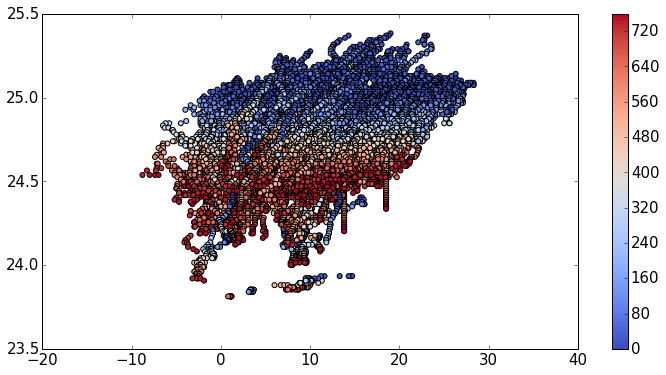

In [12]:
vlimup = 30
vlimlow = 2
hhmmnightstart = 2400
hhmmnightend = 800
hhmmdaystart = hhmmnightend
hhmmdayend = hhmmnightstart

ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow)  
                                          & (data1.UBV < vlimup) 
                                          & ((data1.hhmm < hhmmnightend) | (data1.hhmm > hhmmnightstart) ) ))
#ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow) 
#                                          & (data1.UBV < vlimup) 
#                                          & ((data1.hhmm < hhmmdayend) | (data1.hhmm > hhmmdaystart) ) ))


tlow = -10
tup = 30
tdata1 = ndata1.getnewdatasetcond(np.where( (ndata1.tempLL > tlow) & (ndata1.tempLL < tup) ))
#tdata1.filterHP(1.5)

fig = plt.figure(figsize=(12,6))
plt.scatter(tdata1.tempLL,tdata1.UBV,marker='.',s=100, c=tdata1.hhmm, cmap=plt.cm.coolwarm)
plt.colorbar()

11
[[Variables]]
    a1:  -110.972562 +/- 1.583504 (1.43%) (init=-100)
    b1:   2842.12489 +/- 39.21168 (1.38%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-113.3 x + 2900
11
[[Variables]]
    a1:  -119.969879 +/- 1.131626 (0.94%) (init=-100)
    b1:   3073.49079 +/- 27.98045 (0.91%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-119 x + 3048
11
[[Variables]]
    a1:  -109.777568 +/- 3.225676 (2.94%) (init=-100)
    b1:   2840.62759 +/- 79.82655 (2.81%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-93.94 x + 2448


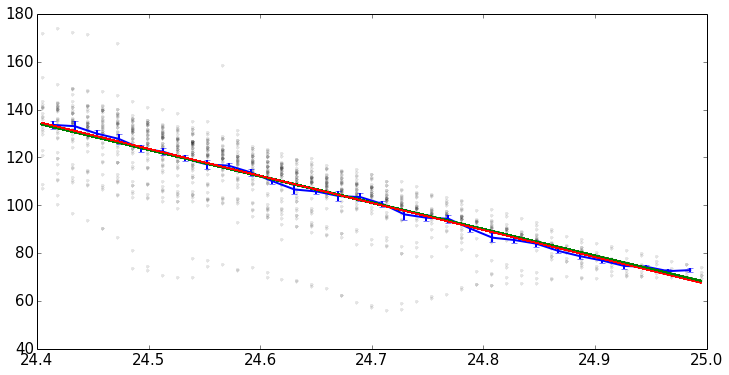

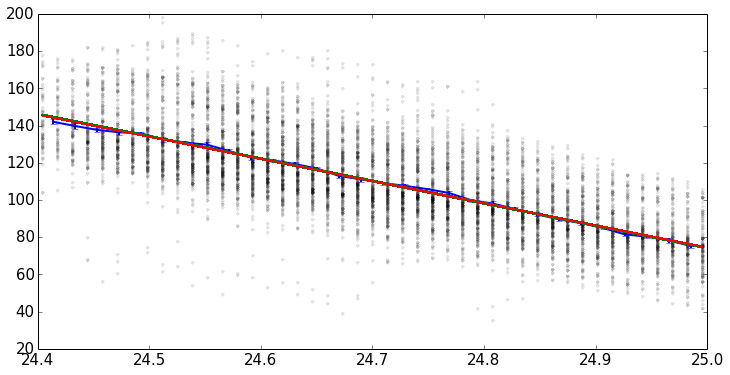

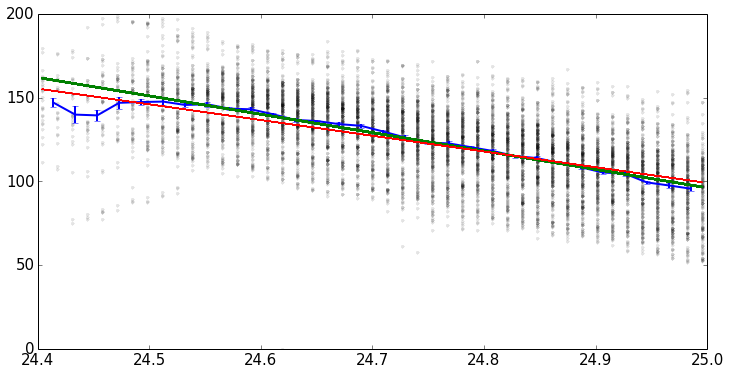

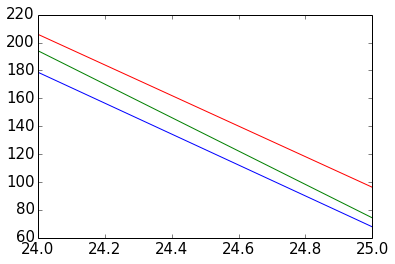

In [55]:
from lmfit import minimize, Parameters, Parameter, report_fit
def fcn2min(params, x, data, dataerr):
    """ model decaying sine wave, subtract data"""
    a1 = params['a1'].value
    b1 = params['b1'].value
    y1 = a1*x + b1
    model = np.array([])
    model = np.append(model,y1)
#    model = a * x + b                                                                                          
    return (model - data)/dataerr

vlimup = 25
vlimlow = 24.4
hhmmnightstart = 2400
hhmmnightend = 800
hhmmdaystart = hhmmnightend
hhmmdayend = hhmmnightstart

ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow)  
                                          & (data1.UBV < vlimup) 
                                          & ((data1.hhmm < hhmmnightend) | (data1.hhmm > hhmmnightstart) ) ))
#ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow) 
#                                          & (data1.UBV < vlimup) 
#                                          & ((data1.hhmm < hhmmdayend) | (data1.hhmm > hhmmdaystart) ) ))

results = []
temp = np.array([-10,0,10,20])
for i in range(len(temp)-1):
    tlow = temp[i]
    tup = temp[i+1]
    tdata1 = ndata1.getnewdatasetcond(np.where( (ndata1.tempLL > tlow) & (ndata1.tempLL < tup) ))
#tdata1.filterHP(1.5)

    x = tdata1.UBV
    y = tdata1.radio
    prof = utils.makeprofile(x,y,30,np.min(x),np.max(x))
    sx = prof[0]
    sy = prof[1]
    params = Parameters()
    params.add('a1', value=-100,max=0)
    params.add('b1', value=2700,vary=True)

    result = minimize(fcn2min, params, args=(sx, sy,prof[3]))
    final = sy + result.residual
    print result.nfev
    report_fit(result.params)
    a1 = result.params['a1'].value
    b1 = result.params['b1'].value
    param = (a1,b1)
    results.append(param)
    fig  = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'k.',zorder=-32,alpha=0.1)
    plt.errorbar(sx, sy,yerr=prof[3],lw=2)
    res1 = result.params['a1'].value*x + result.params['b1'].value

    fit = np.polyfit(sx,sy,1)
    pfit = np.poly1d(fit)
    print pfit
    plt.plot(x,res1,lw=2)
    plt.plot(x, pfit(x))
    
fig = plt.figure()
x = np.linspace(24,25,10)
for r in results:
    plt.plot(x,r[0]*x+r[1])

Now during the day

6003
[[Variables]]
    a1:  -inf        +/- 0        (0.00%) (init=-100)
    b1:  -inf        +/- 0        (0.00%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
 
-107.7 x + 2769
11
[[Variables]]
    a1:  -125.024833 +/- 3.277654 (2.62%) (init=-100)
    b1:   3200.01466 +/- 80.59154 (2.52%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-120.9 x + 3097
11
[[Variables]]
    a1:  -127.633568 +/- 2.583874 (2.02%) (init=-100)
    b1:   3276.72925 +/- 63.46339 (1.94%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-122.5 x + 3149
9
[[Variables]]
    a1:  -104.244494 +/- 5.536002 (5.31%) (init=-100)
    b1:   2710.74457 +/- 136.1366 (5.02%) (init= 2700)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, b1)                    = -1.000 
 
-110.1 x + 2855


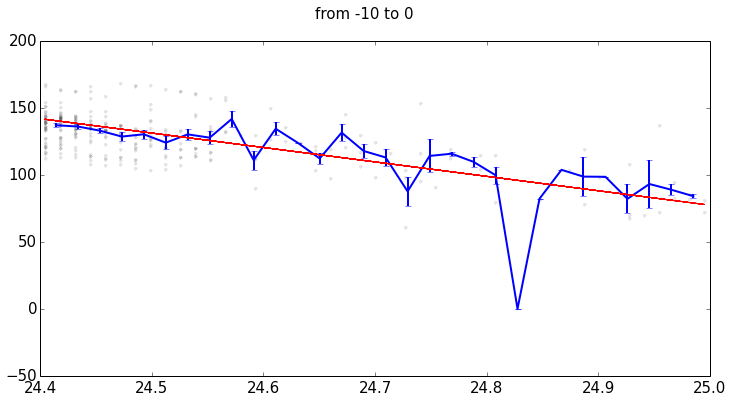

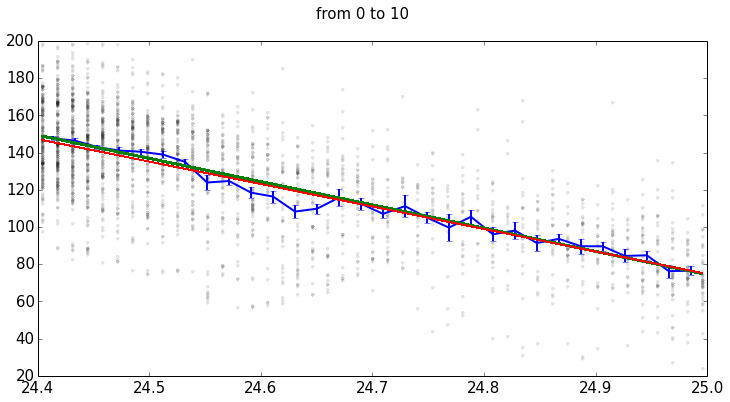

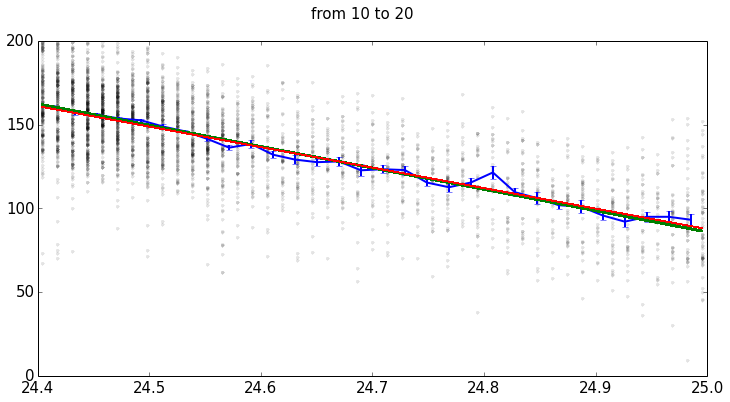

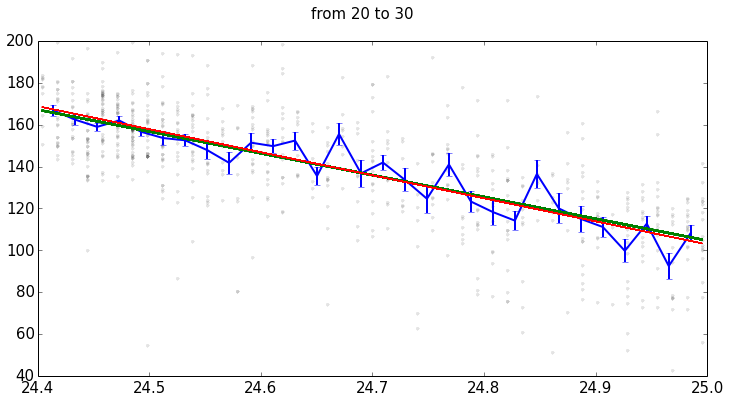

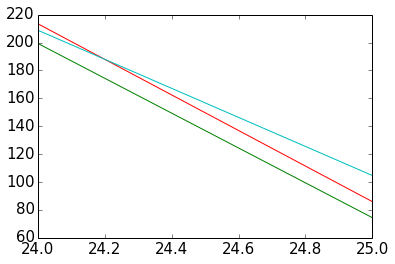

In [62]:
from lmfit import minimize, Parameters, Parameter, report_fit
def fcn2min(params, x, data, dataerr):
    """ model decaying sine wave, subtract data"""
    a1 = params['a1'].value
    b1 = params['b1'].value
    y1 = a1*x + b1
    model = np.array([])
    model = np.append(model,y1)
#    model = a * x + b                                                                                          
    return (model - data)/dataerr

vlimup = 25
vlimlow = 24.4
hhmmnightstart = 2400
hhmmnightend = 800
hhmmdaystart = hhmmnightend
hhmmdayend = hhmmnightstart

#ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow)  
#                                          & (data1.UBV < vlimup) 
#                                          & ((data1.hhmm < hhmmnightend) | (data1.hhmm > hhmmnightstart) ) ))
ndata1 = data1.getnewdatasetcond(np.where((data1.radio < 200) & (data1.UBV>vlimlow) 
                                          & (data1.UBV < vlimup) 
                                          & ((data1.hhmm < hhmmdayend) & (data1.hhmm > hhmmdaystart) ) ))

results = []
temp = np.array([-10,0,10,20,30])
for i in range(len(temp)-1):
    tlow = temp[i]
    tup = temp[i+1]
    tdata1 = ndata1.getnewdatasetcond(np.where( (ndata1.tempLL > tlow) & (ndata1.tempLL < tup) ))
#tdata1.filterHP(1.5)

    x = tdata1.UBV
    y = tdata1.radio
    prof = utils.makeprofile(x,y,30,np.min(x),np.max(x))
    sx = prof[0]
    sy = prof[1]
    params = Parameters()
    params.add('a1', value=-100,max=0)
    params.add('b1', value=2700,vary=True)

    result = minimize(fcn2min, params, args=(sx, sy,prof[3]))
    final = sy + result.residual
    print result.nfev
    report_fit(result.params)
    a1 = result.params['a1'].value
    b1 = result.params['b1'].value
    param = (a1,b1)
    results.append(param)
    fig  = plt.figure(figsize=(12,6))
    fig.suptitle('from '+ str(tlow) + ' to ' + str(tup),fontsize=15)
    plt.plot(x, y, 'k.',zorder=-32,alpha=0.1)
    plt.errorbar(sx, sy,yerr=prof[3],lw=2)
    res1 = result.params['a1'].value*x + result.params['b1'].value

    fit = np.polyfit(sx,sy,1)
    pfit = np.poly1d(fit)
    print pfit
    plt.plot(x,res1,lw=2)
    plt.plot(x, pfit(x))
    
fig = plt.figure()
x = np.linspace(24,25,10)
for r in results:
    plt.plot(x,r[0]*x+r[1])

### new antennas

Here we want to look at other antenna than 434, because the calibration data that we have for this antenna are strange. So we produced the data for 7 other antennas [306,308,315,328,334,403,408].  
We want to look at how good the correction does. 

In [15]:
%load_ext autoreload
%autoreload 2
#new way to load data
# the basic cuts are already in the select leaf
%matplotlib inline 
srcpwd = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/script'
utilspath =srcpwd + '/utils/'
sys.path.append(utilspath)
import utils
classpath = srcpwd + '/classes/'
sys.path.append(classpath)
import dataset
#datafolder = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/data/332_333/'
datafolder = '/Users/romain/work/Auger/EASIER/LPSC/monitoring/data/easier61/'
#fname = 'Antenna_2014-01-01_2014-01-30.root'
fname = 'Antenna_2014-01-01_2014-12-31.root'                                                                                                        
file = datafolder + fname

data = dataset.Dataset(file)
data.loaddata()
pfile = '/Users/romain/work/Auger/EASIER/LPSC/suntransit/data/period/controlperiod_Tsys_50K_below_2adc.txt'
data.loadperiod(pfile) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#load the data for 308
station = 308
data1 = data.getnewdatawithid(station)
pfile = '/Users/romain/work/Auger/EASIER/LPSC/suntransit/data/period/controlperiod_Tsys_50K_below_2adc.txt'
data1.selectleafs()
data1.correctsaturation()

- we had to add a correction for the "saturation" effect which is not exactly saturation. It is just the happening in monitoring: when the baseline goes above 655 ADC, it goes back to zero (this is caused by the type on which the baseline is coded)

154.25
-154.01


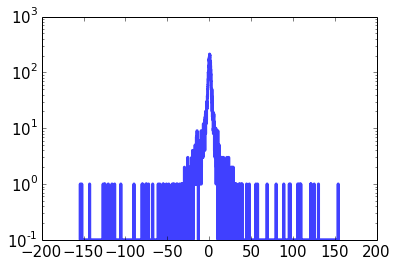

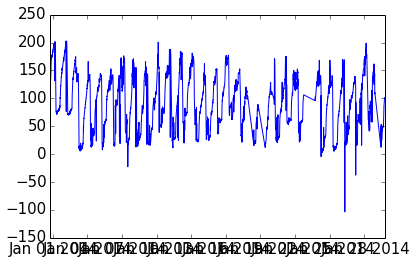

In [3]:
ndata1 = data1.getnewdatasetcond(np.where( (data1.UBV >1) & (data1.humLL < 50) ))
t0 = utils.datettotimestamp(datetime.datetime(2014,1,1))
t1 = utils.datettotimestamp(datetime.datetime(2014,1,30))
ndata1 = ndata1.getnewdataset(t0,t1)
radio = ndata1.radio
radioshift = np.roll(radio,1)

n0, bins0, patches0 = plt.hist(radio-radioshift,2000, histtype='step', lw=3, alpha=0.75,log=True,label='in time')
print np.max(radio-radioshift)
print np.min(radio-radioshift)
fig = plt.figure()
plt.plot(ndata1.date,radio)

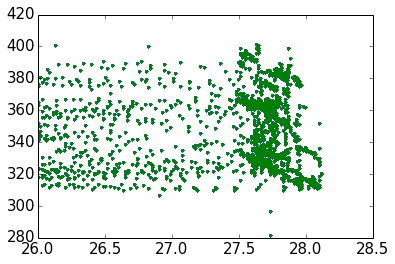

In [4]:
ndata1 = data1.getnewdatasetcond(np.where((data1.UBV >26) & (data1.humLL < 50) ))
t0 = utils.datettotimestamp(datetime.datetime(2014,1,1))
t1 = utils.datettotimestamp(datetime.datetime(2014,1,30))
ndata1 = ndata1.getnewdataset(t0,t1)
ndata1.loadparams()
params = ndata1.params
cradio = ndata1.correctUBV(params[station])
#plt.plot(ndata1.date,ndata1.UBV,'.')
plt.plot(ndata1.UBV,ndata1.radio,'.')
plt.plot(ndata1.UBV,cradio,'.')

-check if the 7 stations we have are fine when corrected:

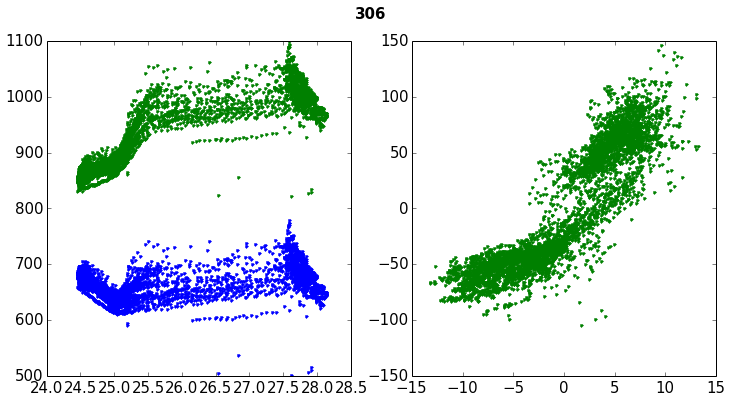

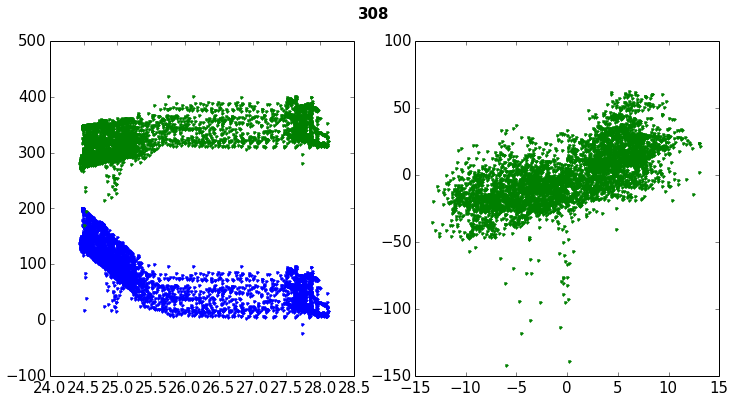

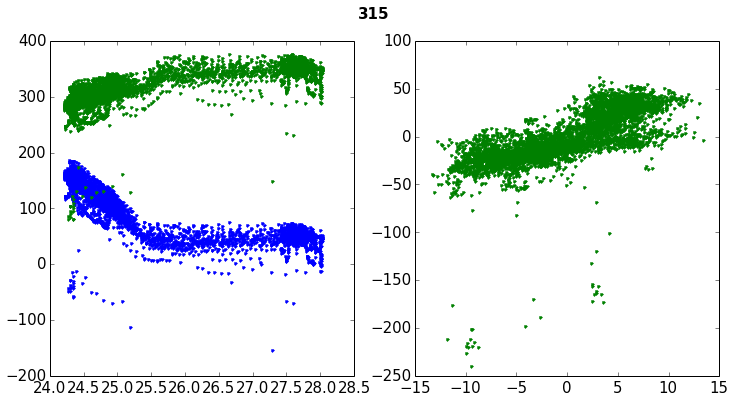

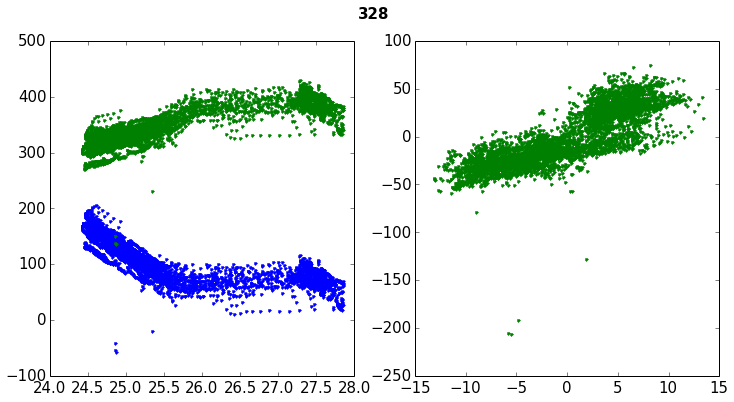

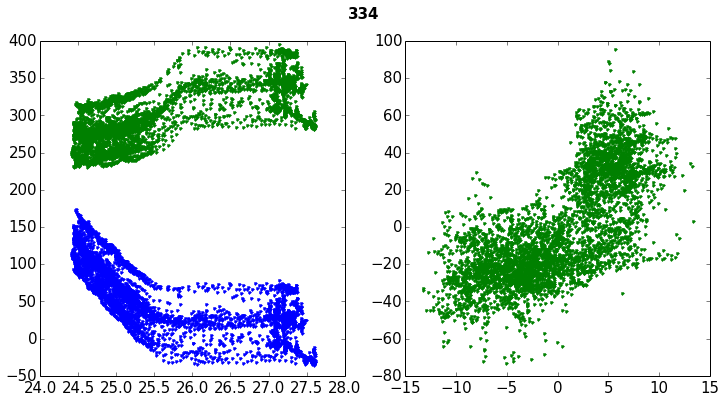

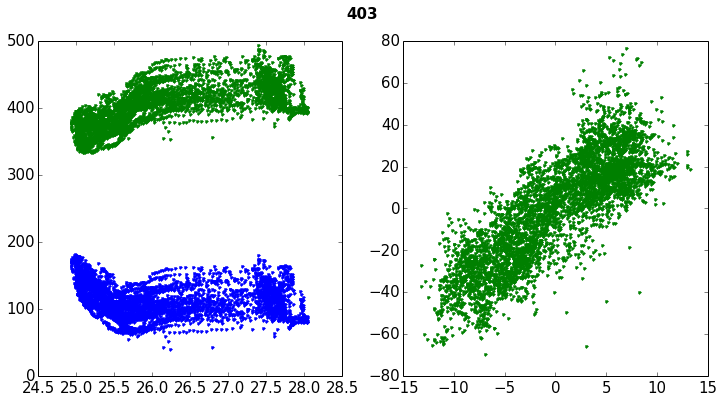

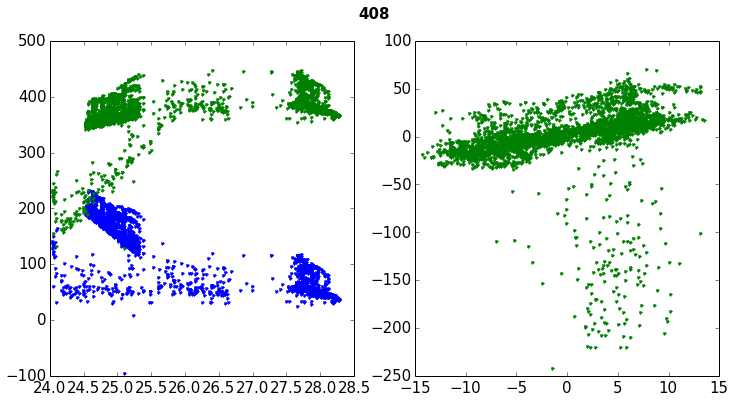

In [14]:
#list of station
st = [306,308,315,328,334,403,408]
for s in st:
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(str(s), fontsize=15,fontweight='bold')
    plt.subplot(121)
    data1 = data.getnewdatawithid(s)
    data1.selectleafs()
    data1.correctsaturation()
    ndata1 = data1.getnewdatasetcond(np.where((data1.UBV > 24) & (data1.humLL < 40) ))
    ndata1.loadparams()
    params = ndata1.params
    plt.plot(ndata1.UBV,ndata1.radio,'.')
    cradio = ndata1.correctUBV(params[s])
    plt.plot(ndata1.UBV,cradio,'.')
    ndata1.filterHP(1.5)
#    plt.plot(ndata1.UBV,cradio,'.')
    plt.subplot(122)
    plt.plot(ndata1.tempLL,ndata1.radio,'g.')

At the end, 408 seems strange, in fact there are data for low voltage which is strange, this is the cause of the strange shape I guess.  
Station 306 is not great neither, it seems worst after the correction. For the rest of the station the correction leads to improvement in term of shape, it is "straighter"

In [ ]:
#list of station
st = [306,308,315,328,334,403,408]
for s in st:
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(str(s), fontsize=15,fontweight='bold')
    plt.subplot(121)
    data1 = data.getnewdatawithid(s)
    data1.selectleafs()
    data1.correctsaturation()
    ndata1 = data1.getnewdatasetcond(np.where((data1.UBV > 24) & (data1.humLL < 40) ))
    ndata1.loadparams()
    params = ndata1.params
    plt.plot(ndata1.UBV,ndata1.radio,'.')
    cradio = ndata1.correctUBV(params[s])
    plt.plot(ndata1.UBV,cradio,'.')
    ndata1.filterHP(1.5)
#    plt.plot(ndata1.UBV,cradio,'.')
    plt.subplot(122)
    plt.plot(ndata1.tempLL,ndata1.radio,'g.')
    